In [ ]:
# init repo notebook
!git clone https://github.com/rramosp/ppdl.git > /dev/null 2> /dev/null
!mv -n ppdl/content/init.py ppdl/content/local . 2> /dev/null
!pip install -r ppdl/content/requirements.txt > /dev/null

# Distribution Layers

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
from progressbar import progressbar as pbar
from rlxutils import subplots, copy_func
import seaborn as sns
import pandas as pd 

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

%matplotlib inline

2022-03-08 06:24:42.627938: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-08 06:24:42.627973: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## The output of a distribution layer is a distribution

In distribution layers:

- the **input** are regular tensors
- the **output** are distributions objects that are use the input tensors as parameters
- the **event_shape** is the number of dimensions
- each **dimension** will be modelled by an independent Normal distribution $\mathcal{N}(\mu, \sigma)$
- each independent normal is governed by **two parameters**

for instance, a 2D independent normal distribution with

$$(x,y) \sim \mathcal{N}_x(-10, 5) \times \mathcal{N}_y(20, 8)$$


In [9]:
inormal_layer = tfp.layers.IndependentNormal(event_shape=1)

In [10]:
inormal_layer.get_config()

{'name': 'independent_normal_2',
 'trainable': True,
 'dtype': 'float32',
 'function': ('4wAAAAAAAAAAAAAAAAcAAAAEAAAAHwAAAHOmAAAAiAF8AGkAfAGkAY4BfQJ0AHwCagF0AmoDgwJ9\nA3wDciyHAGYBZAFkAoQIbgKIAH0EdARqBXwCfARkA40CfQV8BaAGoQB9BnwFfAZfB3wDco58BmQE\nGQBqCHwGXwh8BmQEGQBqCXwGXwl8BmQEGQBqAXwGXwF8BmQEGQBqCHwFXwp8BmQEGQBqCXwFXwlu\nEHwGagh8BV8KfAZqCXwFXwl8BXwGZgJTACkF+kRXcmFwcyBgbWFrZV9kaXN0cmlidXRpb25fZm5g\nIHRvIHJldHVybiBib3RoIGRpc3QgYW5kIGNvbmNyZXRlIHZhbHVlLmMBAAAAAAAAAAAAAAABAAAA\nBAAAABMAAABzDgAAAHQAoAGIAHwAgwGhAVMAqQFOKQLaDHRlbnNvcl90dXBsZdoLVGVuc29yVHVw\nbGUpAdoBZKkB2hRjb252ZXJ0X3RvX3RlbnNvcl9mbqkA+m0vb3B0L2FuYWNvbmRhL2VudnMvcDM5\nL2xpYi9weXRob24zLjkvc2l0ZS1wYWNrYWdlcy90ZW5zb3JmbG93X3Byb2JhYmlsaXR5L3B5dGhv\nbi9sYXllcnMvZGlzdHJpYnV0aW9uX2xheWVyLnB52gg8bGFtYmRhPqkAAADzAAAAAHo6RGlzdHJp\nYnV0aW9uTGFtYmRhLl9faW5pdF9fLjxsb2NhbHM+Ll9mbi48bG9jYWxzPi48bGFtYmRhPikC2gxk\naXN0cmlidXRpb25yBwAAAOn/////KQvaCmlzaW5zdGFuY2XaBWR0eXBl2gtjb2xsZWN0aW9uc9oI\nU2VxdWVuY2XaA2R0Y9oQX1RlbnNvckNvZXJjaWJsZdoGX3ZhbHVl2

calling the layer with some input data produces a distribution object **PARAMETRIZED BY THE INPUT DATA**

- you get a distribution **for each row** (or elements in dimension 0) of the input data.


In [11]:
input_x = np.random.randint(5, size=(2,2))*1.+5

print(input_x)
output_distribution = inormal_layer(input_x)
type(output_distribution)

[[8. 9.]
 [9. 6.]]


2022-03-08 06:27:38.111928: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-08 06:27:38.111977: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-08 06:27:38.112010: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rlxyoga): /proc/driver/nvidia/version does not exist
2022-03-08 06:27:38.113438: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-08 06:27:38.158592: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but 

tensorflow_probability.python.layers.internal.distribution_tensor_coercible._TensorCoercible

In [12]:
output_distribution.batch_shape

TensorShape([2])

In [13]:
# which we can use as any distribution object
s = output_distribution.sample(1000).numpy()
s.shape

(1000, 2, 1)

In [14]:
print ("means", np.mean(s, axis=0)[:,0])
print ("stds ", np.std(s, axis=0)[:,0])

means [8.07702  8.886362]
stds  [9.426311 6.080694]


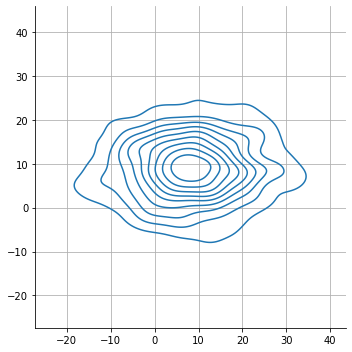

In [15]:
ev = 0
sns.displot(
    x = s[:,0,ev],
    y = s[:,1,ev],
    kind="kde", rug=False
)
plt.axis("equal")
plt.grid();

the **batch size** fo the distribution is determined by the input data shape.

- the **last dimension** of the input data must match the number of parameters required by the distribution
- the **remaining dimensions** determine the distributions `batch_shape`

In [16]:
input_x = np.random.randint(5, size=(2,3,4,2))*1.+5
print(input_x)
output_distribution = inormal_layer(input_x)
output_distribution.batch_shape

[[[[5. 7.]
   [6. 8.]
   [8. 5.]
   [9. 5.]]

  [[6. 6.]
   [9. 6.]
   [6. 6.]
   [7. 7.]]

  [[9. 9.]
   [6. 8.]
   [9. 8.]
   [5. 8.]]]


 [[[9. 8.]
   [7. 8.]
   [6. 8.]
   [9. 9.]]

  [[5. 5.]
   [8. 8.]
   [5. 7.]
   [9. 6.]]

  [[6. 9.]
   [6. 7.]
   [6. 8.]
   [6. 7.]]]]


TensorShape([2, 3, 4])

observe how continuous input data can parametrize a continuum of distributions

In [17]:
x = np.linspace(0,2*np.pi,100)
input_x = np.vstack([np.sin(x), 1+np.cos(x*2)]).T
input_x.shape

(100, 2)

In [18]:
output_distribution = inormal_layer(input_x)
output_distribution.batch_shape

TensorShape([100])

In [19]:
s = output_distribution.sample(10000).numpy()[:,:,0]
s.shape

(10000, 100)

so, for each `x` we have a different distribution (with different mean and std) and we have a sample of 10K elements of each distribution

Text(0.5, 0, 'x')

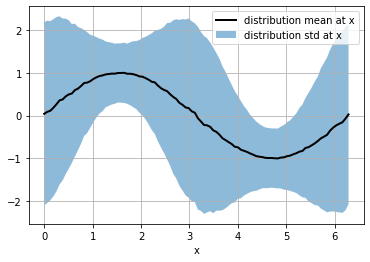

In [20]:
smean = np.mean(s, axis=0)
sstd  = np.std(s, axis=0)

plt.plot(x, smean, color="black", lw=2, label="distribution mean at x")
plt.fill_between(x, smean-sstd, smean+sstd, alpha=.5, label="distribution std at x")
plt.grid(); plt.legend(); plt.xlabel("x")

the probability of the `output_distribution` is the probability for each distribution in the generated batch.

$$\texttt{distribution.log_prob(x)}= \sum_d \sum_k \log P_d(x_k) \; \; \; \forall x_k \in \mathbf{x}\text{ and each distribution }d\text{ in the batch}$$

and $\mathbf{x}$ must comply with the `batch_size` of the distribution batch,

note the difference between 

- `input_x`, which is the input data to the distribution layer and produces a distribution (a batch of distributions)
- `x`, which is the data to which we compute probabilities using the output of the distribution layer.

In [139]:
# some example points
input_x = np.r_[[[10.,1.],[11.,2.], [12.,3.]]]
output_distribution = inormal_layer(input_x)
output_distribution.batch_shape

TensorShape([3])

In [140]:
x = np.linspace(10,12,6)
print (x)
output_distribution.log_prob(x)

[10.  10.4 10.8 11.2 11.6 12. ]


<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ -9.699949, -10.351176, -12.675131], dtype=float32)>

In [141]:
# create a scipy.stats distribution for each input_x
distrs = [stats.norm(*i) for i in input_x]

[np.sum(np.log(i.pdf(x))) for i in distrs]

[-9.913631199228035, -10.022514282587707, -12.594193820125582]

## Distribution layer in a Keras model

the previous layer **MUST** provide the shape of the parameters required by the distribution layer.

Either from an input layer directly.

In [48]:
input_x = np.random.randint(5, size=(3,2))*1.+5
print (input_x)

inp  = tf.keras.layers.Input(shape=(2,))
out  = tfp.layers.IndependentNormal(1)(inp)

m    = tf.keras.models.Model(inp, out)

[[5. 9.]
 [5. 9.]
 [8. 7.]]


In [49]:
moutput = m(input_x)
moutput

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[3] event_shape=[1] dtype=float32>

In [50]:
s = moutput.sample(10000).numpy()[:,:,0]
s.shape

(10000, 3)

In [51]:
print ("means", np.mean(s, axis=0))
print ("stds ", np.std(s, axis=0))

means [5.0123467 5.0472274 8.039777 ]
stds  [8.997255  8.847788  7.1187677]


**The `.predict` of a model with a distribution layer output is a sample (by default)**

In [52]:
m.predict(input_x)

array([[-3.8559008],
       [19.388023 ],
       [ 5.0254173]], dtype=float32)

**We can, of course, use other layers previous to the distribution layer and the `input_x` is transformed accordingly**

and everything is learnable.

In [180]:
input_x = np.random.random(size=(3,5))+.1
print (input_x)

inp  = tf.keras.layers.Input(shape=(5,))
den  = tf.keras.layers.Dense(2, activation="sigmoid", name="dense", bias_initializer="glorot_uniform")(inp)
out  = tfp.layers.IndependentNormal(1)(den)

m    = tf.keras.models.Model(inp, out)

[[1.009664   0.55301791 0.62143092 0.1414634  0.16226084]
 [1.09063203 0.99716617 0.61228457 0.42877567 0.14910155]
 [1.05257904 0.90082675 0.26170321 0.35503394 0.77613307]]


In [181]:
moutput = m(input_x)
moutput

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[3] event_shape=[1] dtype=float32>

In [182]:
s = moutput.sample(100000).numpy()[:,:,0]
s.shape

(100000, 3)

the sample means and stds correspond to the **transformed** `input_x` according to the intermediate dense layer.

observe that in this setting, the `IndependantNormal` layer passes the std parameter through a [`tf.keras.activations.softplus`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softplus) transformation to ensure the standard deviation is $>0$

In [183]:
print ("means", np.mean(s, axis=0))
print ("stds ", np.std(s, axis=0))

means [0.11219823 0.06530911 0.0980479 ]
stds  [1.0946325 1.1205078 1.1397614]


In [184]:
W, b = m.get_layer("dense").get_weights()
input_x.shape, W.shape, b.shape

((3, 5), (5, 2), (2,))

In [185]:
sigm = lambda x: 1/(1+np.exp(-x))
params = sigm(input_x.dot(W) +b)
params

array([[0.11328718, 0.69129696],
       [0.0637393 , 0.72553953],
       [0.10460352, 0.7521605 ]])

In [186]:
print ("means         ", params[:,0])
print ("softplus stds ", np.log(np.exp(params[:,1])+1))

means          [0.11328718 0.0637393  0.10460352]
softplus stds  [1.09737919 1.12032335 1.13833888]
